In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_731597/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs
import random
import os
import time

plt.rcParams.update({'font.size':18})

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

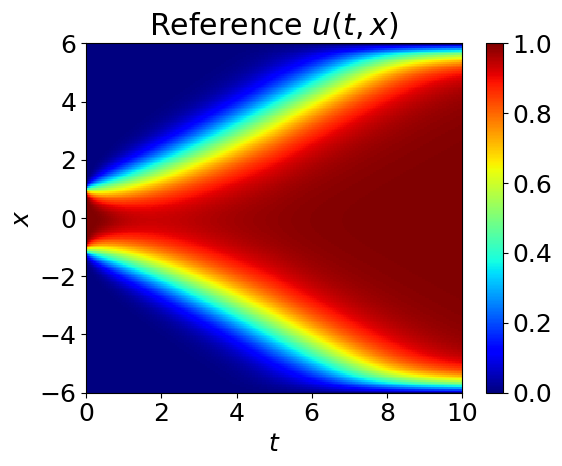

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 21 12:11:16 2023',
 '__version__': '1.0',
 '__globals__': [],
 'C': array([[1, 2]], dtype=uint8),
 'C_t': array([[ 0.2,  1. , -1. ],
        [ 0.1,  1. , -1. ]]),
 'T': array([[10]], dtype=uint8),
 'Time': array([[10]], dtype=uint8),
 'a': array([[-6]], dtype=int16),
 'b': array([[6]], dtype=uint8),
 'h': array([[0.06]]),
 'jump_time_point': array([[ 0],
        [ 5],
        [10]], dtype=uint8),
 'solution': array([[1.92874985e-22, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.51441136e-22, 3.84751374e-22, 4.31921353e-22, ...,
         9.90659535e-02, 9.91484454e-02, 9.92303005e-02],
        [6.40367501e-22, 7.89693237e-22, 9.66503734e-22, ...,
         1.95288538e-01, 1.95448948e-01, 1.95608117e-01],
        ...,
        [1.31989579e-30, 1.62767908e-30, 1.99211267e-30, ...,
         1.91905731e-01, 1.92091981e-01, 1.92276833e-01],
        [7.2437417

In [4]:
data = scipy.io.loadmat('./two-state(0.2-0.1).mat')
# data = scipy.io.loadmat('./three-state(0.05-0.1-0.2-0.1-0.05).mat')
t = data['t'].flatten()
x = data['x'].flatten()
u_data = data['solution']
# 生成网格
TT, XX = np.meshgrid(t, x)
# 画图
fig = plt.figure(figsize=(6, 5))
plt.subplot(111)
plt.pcolor(TT, XX, u_data, cmap='jet')
plt.colorbar()
plt.xlim([0, 10])
plt.ylim([-6, 6])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $u(t,x)$')
plt.tight_layout()
plt.show()

data

## 超参数

In [5]:
domain = (0, 10, -6, 6)
tmin, tmax, xmin, xmax = domain
backbone_layers = [2] + [40]*4 + [1]
nn_lam_layers = [1] + [20]*4 + [1]
adam_iters = 200000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [6]:
class DatasetBurgers:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, verbose=None):
        tmin, tmax, xmin, xmax = self.domain
        # 内部点采样
        t_res = np.linspace(tmin, tmax, 50)
        x_res = np.linspace(xmin, xmax, 80)
        X_res = self.sample_xy(t_res, x_res)
        # 真实数据
        X_data, u_data = self.added_data()
        
        return X_res, X_data, u_data
    
    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X
    
    def added_data(self):
        data = scipy.io.loadmat('./two-state(0.2-0.1).mat')
        u_data = data['solution']
        t = data['t']
        x = data['x']
        
        TT, XX = np.meshgrid(t, x)  # meshgrid之后的数组shape为(nx, nt)
        
        X_data = np.concatenate([TT.reshape(-1, 1), XX.reshape(-1, 1)], axis=1)
        u_data = u_data.reshape(-1, 1)
        
        # 随机采样一小批数据 用以反演
        idx = np.random.permutation(range(X_data.shape[0]))
        idx = idx[:4000]  # 采样4000个真实数据点
        return X_data[idx, :], u_data[idx, :]
    

dataset = DatasetBurgers(domain)
X_res, X_data, u_data = dataset.train_data()
print(X_res.shape, X_data.shape, u_data.shape)

(4000, 2) (4000, 2) (4000, 1)


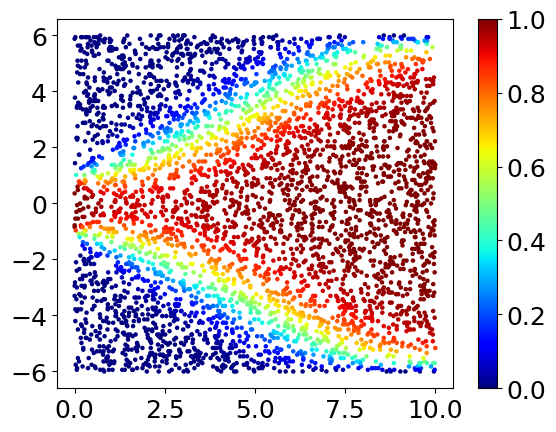

In [7]:
# 随即采样真实数据
plt.scatter(X_data[:, 0], X_data[:, 1], c=u_data[:, 0], s=5, cmap='jet')
plt.colorbar()

## 主干网络

In [8]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)
    

backbone = MLP(backbone_layers)
nn_lam = MLP(nn_lam_layers)

## PINN模型

In [9]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [10]:
class PINNFisher(nn.Module):
    def __init__(self, backbone, nn_lam, mu=None, sigma=None):
        super(PINNFisher, self).__init__()
        self.backbone = backbone
        self.nn_lam = nn_lam
        
        self.bound = 0.15
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
    
    def forward(self, X_res, X_data, u_data):
        loss_res = torch.mean(self.net_f(X_res)**2)
        loss_data = torch.mean(self.net_data(X_data, u_data)**2)
        return loss_res, loss_data
    
    def net_M(self, t):
        if self.is_inputs_normalization == True:
            t = (t - self.mu[0]) / self.sigma[0]
        M_t = self.nn_lam(t)
        return M_t * self.bound
    
    def net_u(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
    
    def net_f(self, X_res):
        X_res.requires_grad_(True)
        u = self.net_u(X_res)
        
        grad_u = grad(u, X_res)[0]
        u_t = grad_u[:,[0]] 
        u_x = grad_u[:,[1]]
        u_xx = grad(u_x, X_res)[0][:,[1]]
        
        M = self.net_M(X_res[:, [0]])

        f = u_t + M*u_xx - u + u**2
        return f
    
    def net_data(self, X_data, u_data):
        u_data_pred = self.net_u(X_data)
        data = u_data_pred - u_data
        return data
    
pinn = PINNFisher(backbone, nn_lam)

## Adams

In [11]:
dataset = DatasetBurgers(domain)  # 生成训练数据
X_res, X_data, u_data = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_data = torch.from_numpy(X_data).float().to(device)
u_data = torch.from_numpy(u_data).float().to(device)

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNFisher(backbone, nn_lam).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)
optimizer_adam_lam = optim.Adam(pinn.nn_lam.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.9)  # 指数衰减学习率
lr_sche_lam = optim.lr_scheduler.ExponentialLR(optimizer_adam_lam, gamma=0.9)

# 自适应
# w_res = torch.cat((torch.ones(1500,1 ),100 * torch.ones(1000,1 ),torch.ones(1500,1 )),dim=0).float().to(device)  # 权重
# # # w_data = (100 * torch.ones(X_data.shape[0],1 )).float().to(device)
# w_data = torch.cat((torch.ones(1500,1 ),100 * torch.ones(1000,1 ),torch.ones(1500,1 )),dim=0).float().to(device)
# print(w_res.shape)

# w_res.requires_grad = True
# w_data.requires_grad = True

# optimizer_w_res = optim.Adam([w_res], lr=1e-3, betas=(0.9, 0.999))  # 权重优化器
# optimizer_w_data = optim.Adam([w_data], lr=1e-3, betas=(0.9, 0.999))


logger = {
    "loss": [], 
    "loss_res": [],
    "loss_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    # 计算loss并更新网络 -------
    pinn.train()
    pinn.zero_grad()
    
    loss_res, loss_data = pinn(X_res, X_data, u_data)
#     loss_res = torch.mean(w_res * pinn.net_f(X_res)**2)
#     loss_data = torch.mean(w_data * pinn.net_data(X_data, u_data)**2)
    loss = 1000*(loss_res +  loss_data)
    
    loss.backward()
    optimizer_adam.step()
    optimizer_adam_lam.step()
    # 计算loss并更新网络 -------
    
#     for w in [w_res,w_data]:
#         w.grad *= -1.
#     optimizer_w_res.step()
#     optimizer_w_data.step()
    
    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_res_valid, loss_data_valid = pinn(X_res, X_data, u_data)
        loss_valid = loss_res_valid + loss_data_valid
        
        logger["loss"].append(loss_valid.item())
        logger["loss_res"].append(loss_res_valid.item())
        logger["loss_data"].append(loss_data_valid.item())
        logger["iter"].append(it+1)
        
        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(), 'nn_lam_state': pinn.nn_lam.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()
        
        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it+1:6d}/{adam_iters}\t' + \
                f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_d:{loss_data.item():.2e}  ' + \
                f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_res_valid.item():.2e}, loss_d:{loss_data_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
            
        # 衰减学习率
        if (it + 1) % 5000 == 0:
            lr_sche.step()
            lr_sche_lam.step()

Iter #    500/200000	loss:3.33e+00, loss_r:3.69e-04, loss_d:2.96e-03  Valid # loss:3.33e-03, loss_r:3.69e-04, loss_d:2.96e-03
Iter #   1000/200000	loss:2.61e+00, loss_r:2.23e-04, loss_d:2.39e-03  Valid # loss:2.61e-03, loss_r:2.23e-04, loss_d:2.39e-03
Iter #   1500/200000	loss:2.21e+00, loss_r:1.79e-04, loss_d:2.03e-03  Valid # loss:2.21e-03, loss_r:1.79e-04, loss_d:2.03e-03
Iter #   2000/200000	loss:1.78e+00, loss_r:1.62e-04, loss_d:1.62e-03  Valid # loss:1.78e-03, loss_r:1.62e-04, loss_d:1.62e-03
Iter #   2500/200000	loss:1.40e+00, loss_r:1.57e-04, loss_d:1.24e-03  Valid # loss:1.40e-03, loss_r:1.57e-04, loss_d:1.24e-03
Iter #   3000/200000	loss:1.05e+00, loss_r:1.49e-04, loss_d:9.01e-04  Valid # loss:1.05e-03, loss_r:1.49e-04, loss_d:9.00e-04
Iter #   3500/200000	loss:7.14e-01, loss_r:1.43e-04, loss_d:5.72e-04  Valid # loss:7.14e-04, loss_r:1.43e-04, loss_d:5.71e-04
Iter #   4000/200000	loss:4.48e-01, loss_r:1.18e-04, loss_d:3.30e-04  Valid # loss:4.47e-04, loss_r:1.18e-04, loss_d:3

Iter #  33500/200000	loss:3.70e-02, loss_r:1.15e-05, loss_d:2.55e-05  Valid # loss:4.53e-05, loss_r:1.42e-05, loss_d:3.12e-05
Iter #  34000/200000	loss:1.56e-03, loss_r:7.60e-07, loss_d:7.95e-07  Valid # loss:1.56e-06, loss_r:7.58e-07, loss_d:7.97e-07
Iter #  34500/200000	loss:1.51e-03, loss_r:7.43e-07, loss_d:7.63e-07  Valid # loss:1.50e-06, loss_r:7.42e-07, loss_d:7.62e-07
Iter #  35000/200000	loss:1.48e-03, loss_r:7.39e-07, loss_d:7.43e-07  Valid # loss:1.50e-06, loss_r:7.41e-07, loss_d:7.57e-07
Iter #  35500/200000	loss:1.40e-03, loss_r:7.00e-07, loss_d:7.04e-07  Valid # loss:1.40e-06, loss_r:7.00e-07, loss_d:7.04e-07
Iter #  36000/200000	loss:1.36e-03, loss_r:6.83e-07, loss_d:6.79e-07  Valid # loss:1.36e-06, loss_r:6.83e-07, loss_d:6.79e-07
Iter #  36500/200000	loss:1.33e-03, loss_r:6.71e-07, loss_d:6.57e-07  Valid # loss:1.34e-06, loss_r:6.75e-07, loss_d:6.65e-07
Iter #  37000/200000	loss:4.74e-03, loss_r:1.96e-06, loss_d:2.79e-06  Valid # loss:6.70e-06, loss_r:2.63e-06, loss_d:4

Iter #  66500/200000	loss:6.46e-04, loss_r:3.22e-07, loss_d:3.24e-07  Valid # loss:6.17e-07, loss_r:2.86e-07, loss_d:3.31e-07
Iter #  67000/200000	loss:5.35e-04, loss_r:2.59e-07, loss_d:2.76e-07  Valid # loss:5.35e-07, loss_r:2.59e-07, loss_d:2.76e-07
Iter #  67500/200000	loss:5.39e-04, loss_r:2.60e-07, loss_d:2.79e-07  Valid # loss:7.59e-07, loss_r:3.22e-07, loss_d:4.37e-07
Iter #  68000/200000	loss:5.28e-04, loss_r:2.54e-07, loss_d:2.74e-07  Valid # loss:5.27e-07, loss_r:2.54e-07, loss_d:2.72e-07
Iter #  68500/200000	loss:5.45e-04, loss_r:2.65e-07, loss_d:2.80e-07  Valid # loss:5.54e-07, loss_r:2.70e-07, loss_d:2.83e-07
Iter #  69000/200000	loss:5.19e-04, loss_r:2.50e-07, loss_d:2.69e-07  Valid # loss:5.19e-07, loss_r:2.49e-07, loss_d:2.70e-07
Iter #  69500/200000	loss:5.13e-04, loss_r:2.47e-07, loss_d:2.67e-07  Valid # loss:5.14e-07, loss_r:2.47e-07, loss_d:2.67e-07
Iter #  70000/200000	loss:1.29e-03, loss_r:4.56e-07, loss_d:8.30e-07  Valid # loss:1.05e-06, loss_r:4.16e-07, loss_d:6

Iter #  99500/200000	loss:4.65e-04, loss_r:2.00e-07, loss_d:2.64e-07  Valid # loss:6.77e-07, loss_r:2.54e-07, loss_d:4.23e-07
Iter # 100000/200000	loss:3.60e-04, loss_r:1.62e-07, loss_d:1.98e-07  Valid # loss:3.60e-07, loss_r:1.62e-07, loss_d:1.98e-07
Iter # 100500/200000	loss:4.68e-04, loss_r:1.90e-07, loss_d:2.78e-07  Valid # loss:5.27e-07, loss_r:2.13e-07, loss_d:3.13e-07
Iter # 101000/200000	loss:3.60e-04, loss_r:1.60e-07, loss_d:2.00e-07  Valid # loss:3.58e-07, loss_r:1.61e-07, loss_d:1.98e-07
Iter # 101500/200000	loss:3.55e-04, loss_r:1.59e-07, loss_d:1.96e-07  Valid # loss:3.55e-07, loss_r:1.59e-07, loss_d:1.96e-07
Iter # 102000/200000	loss:3.54e-04, loss_r:1.59e-07, loss_d:1.96e-07  Valid # loss:3.54e-07, loss_r:1.59e-07, loss_d:1.96e-07
Iter # 102500/200000	loss:6.95e-04, loss_r:3.34e-07, loss_d:3.61e-07  Valid # loss:7.53e-07, loss_r:3.54e-07, loss_d:3.99e-07
Iter # 103000/200000	loss:3.52e-04, loss_r:1.57e-07, loss_d:1.94e-07  Valid # loss:3.55e-07, loss_r:1.58e-07, loss_d:1

Iter # 132500/200000	loss:2.90e-04, loss_r:1.24e-07, loss_d:1.66e-07  Valid # loss:2.90e-07, loss_r:1.25e-07, loss_d:1.65e-07
Iter # 133000/200000	loss:2.89e-04, loss_r:1.24e-07, loss_d:1.65e-07  Valid # loss:2.89e-07, loss_r:1.24e-07, loss_d:1.65e-07
Iter # 133500/200000	loss:2.89e-04, loss_r:1.24e-07, loss_d:1.65e-07  Valid # loss:2.89e-07, loss_r:1.24e-07, loss_d:1.65e-07
Iter # 134000/200000	loss:2.89e-04, loss_r:1.24e-07, loss_d:1.65e-07  Valid # loss:2.90e-07, loss_r:1.25e-07, loss_d:1.65e-07
Iter # 134500/200000	loss:3.35e-04, loss_r:1.37e-07, loss_d:1.98e-07  Valid # loss:2.96e-07, loss_r:1.27e-07, loss_d:1.69e-07
Iter # 135000/200000	loss:3.71e-03, loss_r:1.16e-06, loss_d:2.55e-06  Valid # loss:2.13e-06, loss_r:6.38e-07, loss_d:1.49e-06
Iter # 135500/200000	loss:2.85e-04, loss_r:1.22e-07, loss_d:1.63e-07  Valid # loss:2.85e-07, loss_r:1.22e-07, loss_d:1.63e-07
Iter # 136000/200000	loss:2.87e-04, loss_r:1.22e-07, loss_d:1.65e-07  Valid # loss:2.86e-07, loss_r:1.23e-07, loss_d:1

Iter # 165500/200000	loss:2.50e-04, loss_r:1.04e-07, loss_d:1.46e-07  Valid # loss:2.50e-07, loss_r:1.04e-07, loss_d:1.46e-07
Iter # 166000/200000	loss:2.49e-04, loss_r:1.04e-07, loss_d:1.46e-07  Valid # loss:2.49e-07, loss_r:1.04e-07, loss_d:1.46e-07
Iter # 166500/200000	loss:2.49e-04, loss_r:1.03e-07, loss_d:1.46e-07  Valid # loss:2.50e-07, loss_r:1.04e-07, loss_d:1.46e-07
Iter # 167000/200000	loss:3.20e-04, loss_r:1.26e-07, loss_d:1.93e-07  Valid # loss:2.58e-07, loss_r:1.07e-07, loss_d:1.51e-07
Iter # 167500/200000	loss:2.48e-04, loss_r:1.03e-07, loss_d:1.45e-07  Valid # loss:2.48e-07, loss_r:1.03e-07, loss_d:1.45e-07
Iter # 168000/200000	loss:2.48e-04, loss_r:1.03e-07, loss_d:1.45e-07  Valid # loss:2.48e-07, loss_r:1.03e-07, loss_d:1.45e-07
Iter # 168500/200000	loss:2.47e-04, loss_r:1.02e-07, loss_d:1.45e-07  Valid # loss:2.47e-07, loss_r:1.02e-07, loss_d:1.45e-07
Iter # 169000/200000	loss:2.47e-04, loss_r:1.02e-07, loss_d:1.44e-07  Valid # loss:2.47e-07, loss_r:1.02e-07, loss_d:1

Iter # 198500/200000	loss:2.25e-04, loss_r:9.10e-08, loss_d:1.34e-07  Valid # loss:2.25e-07, loss_r:9.10e-08, loss_d:1.34e-07
Iter # 199000/200000	loss:2.24e-04, loss_r:9.08e-08, loss_d:1.34e-07  Valid # loss:2.24e-07, loss_r:9.08e-08, loss_d:1.34e-07
Iter # 199500/200000	loss:2.39e-04, loss_r:9.59e-08, loss_d:1.43e-07  Valid # loss:2.50e-07, loss_r:1.01e-07, loss_d:1.49e-07
Iter # 200000/200000	loss:2.24e-04, loss_r:9.05e-08, loss_d:1.33e-07  Valid # loss:2.24e-07, loss_r:9.05e-08, loss_d:1.33e-07


In [12]:
np.save("./logger.npy", logger)

## 结果可视化

In [13]:
plt.rcParams.update({'font.size':20})

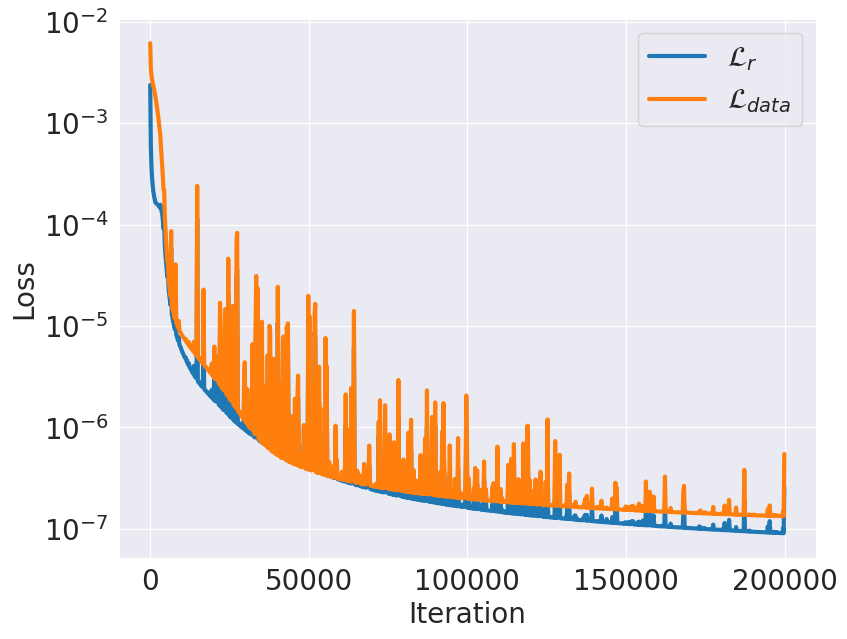

In [14]:
logger = np.load("./logger.npy", allow_pickle=True).item()
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(logger["iter"][::k], logger["loss_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_data"][::k], label=r"$\mathcal{L}_{data}$", linewidth=3)
    plt.legend()
#     plt.xticks([0, 10000, 20000, 30000, 40000])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss.png', dpi=100)
    plt.show()

In [15]:
# 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNFisher(backbone, nn_lam)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])
pinn.eval()

# 导入数据
data = scipy.io.loadmat('./two-state(0.2-0.1).mat')
u_star = data['solution']
t = data['t'].flatten()
x = data['x'].flatten()
# 生成网格
TT, XX = np.meshgrid(t, x)
TX = np.concatenate([TT.reshape(-1,1), XX.reshape(-1,1)], axis=1)
TX = torch.from_numpy(TX).double()

pinn = pinn.cpu().double()
u_pred = pinn.net_u(TX).detach().numpy()
u_pred = u_pred.reshape(TT.shape)

u_error = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) 
print('Relative l2 error of u: {:.3e}'.format(u_error))

Relative l2 error of u: 3.269e-03


In [16]:
def M_true(t):
    M_true = np.zeros(t.shape)
    for i in range(len(t)):
        if (t[i]>=0) and (t[i]<=5):
            M_true[i] = 0.2
        else:M_true[i] = 0.1 
    return M_true

In [17]:
t = torch.tensor(t.reshape(-1,1))  # 1001,1
M_pred = pinn.net_M(t).detach().numpy()  # 1001,1

M_true = M_true(t)
M_error = np.linalg.norm(M_pred - M_true) / np.linalg.norm(M_true)

print('Relative l2 error of M: {:.3e}'.format(M_error))
print(M_true)

Relative l2 error of M: 1.974e+00
[[0.2]
 [0.2]
 [0.2]
 ...
 [0.1]
 [0.1]
 [0.1]]


In [18]:
M_pred[480:520]

array([[-0.16245204],
       [-0.16172038],
       [-0.16098601],
       [-0.16024906],
       [-0.15950969],
       [-0.15876803],
       [-0.15802424],
       [-0.15727846],
       [-0.15653083],
       [-0.15578152],
       [-0.15503066],
       [-0.15427842],
       [-0.15352493],
       [-0.15277036],
       [-0.15201485],
       [-0.15125855],
       [-0.15050163],
       [-0.14974423],
       [-0.1489865 ],
       [-0.14822861],
       [-0.1474707 ],
       [-0.14671292],
       [-0.14595543],
       [-0.14519839],
       [-0.14444194],
       [-0.14368624],
       [-0.14293144],
       [-0.14217769],
       [-0.14142514],
       [-0.14067394],
       [-0.13992424],
       [-0.1391762 ],
       [-0.13842995],
       [-0.13768565],
       [-0.13694344],
       [-0.13620346],
       [-0.13546587],
       [-0.1347308 ],
       [-0.13399839],
       [-0.13326879]])

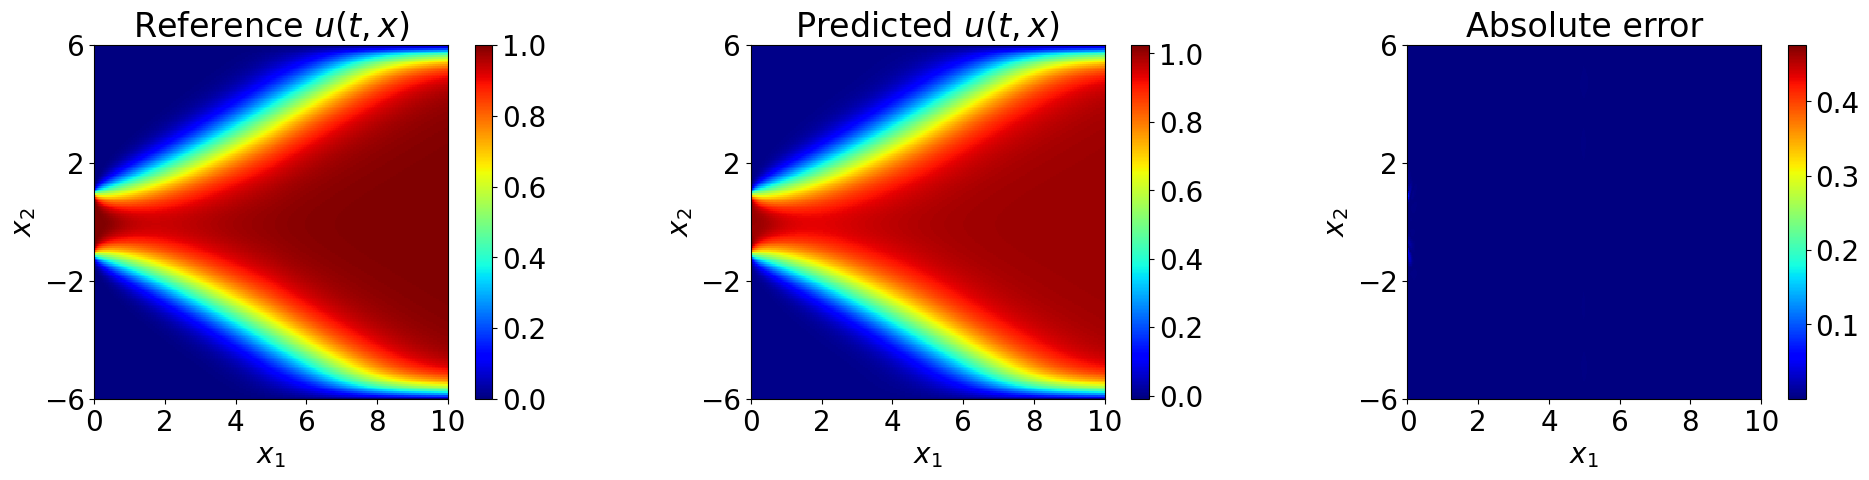

In [19]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
cax1 = axes[0].pcolor(TT, XX, u_star, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u(t,x)$')
axes[0].set_xlim([0, 10])
axes[0].set_ylim([-6, 6])
axes[0].set_xticks(np.arange(0, 10.1, 2.))
axes[0].set_yticks(np.arange(-6, 6.1, 4.))
axes[0].set_aspect(1./axes[0].get_data_ratio())

plt.subplot(1,3,2)
cax2 = axes[1].pcolor(TT, XX, u_pred, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[1].set_xlim([0, 10])
axes[1].set_ylim([-6, 6])
axes[1].set_xticks(np.arange(0, 10.1, 2.))
axes[1].set_yticks(np.arange(-6, 6.1, 4.))
axes[1].set_aspect(1./axes[1].get_data_ratio())

plt.subplot(1,3,3)
cax3 = axes[2].pcolor(TT, XX, np.abs(u_star - u_pred), cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_xlim([0, 10])
axes[2].set_ylim([-6, 6])
axes[2].set_xticks(np.arange(0, 10.1, 2.))
axes[2].set_yticks(np.arange(-6, 6.1, 4.))
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('Fisher_result.png', dpi=100, bbox_inches='tight')
plt.show()

/tmp/ipykernel_731597/3489227405.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t.reshape(-1,1))  # 1001,1


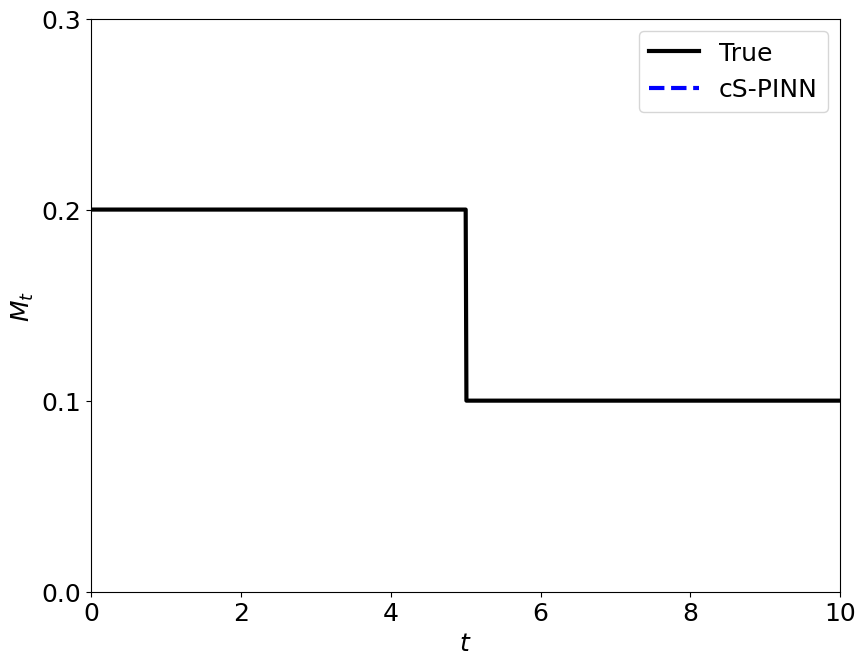

In [20]:
plt.rcParams.update({'font.size':18})

fig, ax = plt.subplots(figsize=(9, 7), dpi=100)
# lines = ax.plot(t[:-1].reshape(5, -1).T, lam2_sol[:-1].reshape(5, -1).T, 
#                 linewidth=3, color='k', label="True")
# plt.setp(lines[1:], label="_")

t = torch.tensor(t.reshape(-1,1))  # 1001,1
M = pinn.net_M(t).detach().numpy()  # 1001,1
t = np.array(t)

ax.plot(t, M_true, linewidth=3, linestyle='-', color='black', label='True')
# ax.scatter(t[::20], M[::20], marker='^', s=120, color='blue', label='cS-PINN')
ax.plot(t, M, linewidth=3, linestyle='--', color='blue', label='cS-PINN')
ax.set_xlim([0, 10])
ax.set_xticks(np.arange(0, 10.1, 2))
ax.set_xlabel('$t$')
ax.set_ylim([0., 0.3])
ax.set_yticks(np.arange(0., 0.31, 0.1))
ax.set_ylabel('$M_t$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("./M.png", dpi=100)
plt.show()